In [1]:
#Dependencies
import pandas as pd
import numpy as np
import itertools

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm


ROOT_DIR = os.getcwd()
STATE_SIZE = 10

In [2]:
#Loading datasets
ratings_df = pd.read_csv("ratings.dat")
users_df = pd.read_csv("users.dat")
movies_df = pd.read_csv("movies.dat")

In [3]:
ratings_df.head(2)

,UserID,MovieID,Rating,Timestamp
0,259,255,4,874724710
1,259,286,4,874724727


In [4]:
ratings_df[ratings_df['Rating']<=3].count

<bound method DataFrame.count of        UserID  MovieID  Rating  Timestamp
7         259      288       3  874724905
11        259      405       3  874725120
12        259     1074       3  874725264
16        851      687       2  874728168
17        851      696       3  874728338
...       ...      ...     ...        ...
99984     729      894       1  893286511
99985     683      472       3  893286550
99986     683      626       3  893286550
99996     729      313       3  893286638
99997     729      328       3  893286638

[44625 rows x 4 columns]>

In [5]:
t1 = ratings_df[ratings_df['UserID']<=755]
t1.shape

(81239, 4)

In [6]:
t1.head(2)

,UserID,MovieID,Rating,Timestamp
0,259,255,4,874724710
1,259,286,4,874724727


In [7]:
t2 = ratings_df[ratings_df['UserID']>755]
t2.shape

(18761, 4)

In [8]:
t2.head(2)

,UserID,MovieID,Rating,Timestamp
16,851,687,2,874728168
17,851,696,3,874728338


In [9]:
t3 = t2.groupby('UserID').head(10).reset_index(drop=True)
t3.shape

(1880, 4)

In [10]:
t3.head(2)

,UserID,MovieID,Rating,Timestamp
0,851,687,2,874728168
1,851,696,3,874728338


In [11]:
t4 = pd.concat([t1, t3], axis=0) 
t4.shape

(83119, 4)

In [12]:
ratings_df = t4

In [13]:
ratings_df.shape

(83119, 4)

In [14]:
users_df.head(2)

,UserID,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [15]:
movies_df.head(2)

,MovieID,movie title,Genre
0,1,Toy Story (1995),"[2, 3, 4]"
1,2,GoldenEye (1995),"[0, 1, 15]"


In [16]:
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [17]:
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [18]:
users_df['UserID'].nunique()

943

In [19]:
movies_df['MovieID'].nunique()

1682

In [20]:
a = ratings_df[ratings_df['MovieID'] == 768]
a.value_counts("Rating")


Rating
3    16
2     7
4     5
5     5
1     3
dtype: int64

# Create a model

In [21]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children's",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western',
         '']

In [22]:
LEN_MOVIES = max(movies_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(ratings_df['UserID'])+1
EMBEDDING_SIZE = 50

In [23]:
LEN_MOVIES

1683

In [24]:
LEN_GENRES

20

In [25]:
LEN_USERS

944

# User batch generator

In [26]:
modified_user_movie_rating_df = ratings_df.apply(np.int32)

index_names = modified_user_movie_rating_df[modified_user_movie_rating_df['Rating']<1].index

In [27]:
modified_user_movie_rating_df = modified_user_movie_rating_df.drop(index_names)
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Rating', axis=1)
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Timestamp', axis=1)
u_m_pairs = modified_user_movie_rating_df.to_numpy()
u_m_pairs[:5]

array([[259, 255],
       [259, 286],
       [259, 298],
       [259, 185],
       [259, 173]])

In [28]:
positive_user_movie_dict = {u : [] for u in range(1, max(modified_user_movie_rating_df['UserID'])+1)}
for data in modified_user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
#positive_user_movie_dict[1]

In [29]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_movie_rating_df['UserID'])+1
    max_movie_id = max(modified_user_movie_rating_df['MovieID'])+1
    
    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)
        
        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [30]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

In [31]:
class TestUserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users,len_movies, embedding_size):
        super(TestUserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        memb = self.m_embedding(x[1])
        m_u = self.m_u_merge([memb, uemb])
        return self.m_u_fc(m_u)

In [32]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [33]:
test_model = TestUserMovieEmbedding(LEN_USERS, LEN_MOVIES, EMBEDDING_SIZE)

test_model([np.zeros((1)),np.zeros((1))])
test_model.summary()

Model: "test_user_movie_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 user_embedding (Embedding)  multiple                  47200     
                                                                 
 movie_embedding (Embedding)  multiple                 84150     
                                                                 
 movie_user_dot (Dot)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  2         
                                                                 
Total params: 131,352
Trainable params: 131,352
Non-trainable params: 0
_________________________________________________________________


In [34]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [35]:
test_train_loss = tf.keras.metrics.Mean(name='train_loss')
test_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def test_train_step(test_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = test_model(test_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, test_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, test_model.trainable_variables))

    test_train_loss(loss)
    test_train_accuracy(labels, predictions)

In [36]:
# for log
test_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    test_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(ratings_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(test_generator)
        test_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {test_train_loss.result():0.4f}, Accuracy: {test_train_accuracy.result() * 100:0.1f}', end='\r')

    test_losses.append(test_train_loss.result())

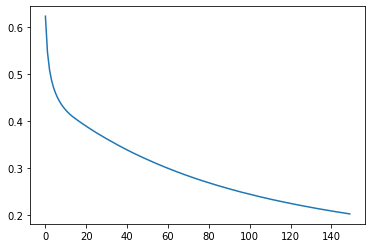

In [37]:
plt.plot(test_losses)

In [38]:
test_model.save_weights('./save_weights/user_movie_at_once.h5')